# Table of Contents
 <p><div class="lev2"><a href="#PRECT-statistics"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>PRECT statistics</a></div><div class="lev2"><a href="#Compare-CRM_PREC-and-PRECT"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Compare CRM_PREC and PRECT</a></div><div class="lev2"><a href="#CRM_PREC-in-percentile-bins-of-PRECT"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>CRM_PREC in percentile bins of PRECT</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib import mplDeprecation
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
import pickle
from scipy.ndimage import convolve

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from importingData import *
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *
from itertools import zip_longest

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [3]:
time_stride = '1h'
resolution = '1dx'

ranks_label = 'Q8-Q41'
dates_label_full = '185005010100-185105010000'
dates_label_med = '185005010100-185009010000'
dates_label_short = '185005010100-185005020000'
dates_label = dates_label_full
dates = tuple(dates_label.split('-'))

In [4]:
print("choose run options")
scaling = 'omega500tsps'
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
# time_ref = '1h'
# res_ref = '1dx'
daskarray = False

choose run options


In [35]:
# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)
handle= 'h0'
os.makedirs(figdir,exist_ok=True)

resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()
print("get inputpaths")

# Local input directory
historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)


get inputpaths


In [6]:
print("load physical variables data")

pr_id = 'PRECT'
crmpr_id = 'CRM_PREC'

pr,crmpr = getValues([pr_id,crmpr_id],
              compset,subset,experiment,time_stride,resolution,
              daskarray=daskarray,dates=dates,handle=handle)

s_crm2D = crmpr.shape

load physical variables data
Importing PRECT, CRM_PREC from 1577 history files between 1850-05-01-03600 and 1850-07-05-61200


## PRECT statistics

In [7]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks_ref,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 427 ms, sys: 19.4 ms, total: 446 ms
Wall time: 433 ms


In [8]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
1280069.0 7266816


In [9]:
print("Mean pr in each bin")
pr_prQ = meanXAtAllYRanks(targetranks,pr,pr,ranks_ref,rank_locations=rank_locations)

Mean pr in each bin


## Compare CRM_PREC and PRECT

There seems to be up to 25% error between PRECT and CRM_PREC

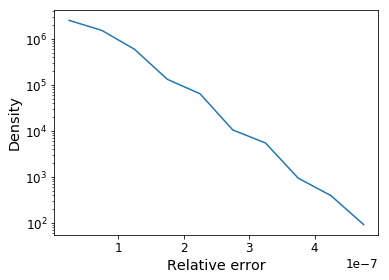

In [10]:
crmpr_avg = np.mean(crmpr,axis=2).squeeze()
err = (np.abs(crmpr_avg-pr)/pr).flatten()
dens,edges = np.histogram(err,range=(0,5e-7))
plt.plot(np.convolve(edges,(0.5,0.5),'valid'),dens)
plt.xlabel('Relative error')
plt.ylabel('Density')
plt.yscale('log')

## CRM_PREC in percentile bins of PRECT

In [11]:
# Function that computes the number of local maxima 
def numLocalMax(x):
    dx = convolve(x,(1,-1),mode='wrap')
    return np.logical_and(dx < 0, np.roll(dx,1) >= 0).sum()

# Function that computes the number of local minima 
def localMin(x):
    dx = convolve(x,(1,-1),mode='wrap')
    return np.logical_and(dx > 0, np.roll(dx,1) <= 0)

# Computes the fraction of rain for each event in decreasing order
def fractionRainPerEvent(x):
    
    """Returns the fraction of crmpr rained in each event in decreasing order,
    and the indices corresponding to the ordering."""
    
    nx = len(x)
    locmin = localMin(x)
    indmin = np.where(locmin)[0]
    x_evt = []
    for k in range(len(indmin)):
        i = indmin[k] 
        j = np.roll(indmin,-1)[k]
        imax = (j-i) % nx
        x_evt.append((np.roll(x,-i)[0:imax]).sum()/float(nx)/np.mean(x))
    ind_sort = np.argsort(x_evt)[::-1]
    x_evt.sort(reverse=True)
    
    return x_evt,ind_sort

99.9601892829
P_Q = 1.45309099123e-06
bin: 1.42566118214e-06 1.47920697734e-06

All values of pr in percentile bin: [  1.44254898e-06   1.44440378e-06   1.47121659e-06   1.43584953e-06
   1.47593653e-06   1.46633295e-06   1.45484614e-06   1.44056230e-06
   1.45034801e-06   1.45329250e-06   1.42603687e-06   1.43920579e-06
   1.47245339e-06   1.46952232e-06   1.45073386e-06   1.45587774e-06
   1.47588946e-06   1.45061097e-06   1.47284322e-06   1.46598336e-06
   1.46072500e-06   1.43427746e-06   1.43083457e-06   1.46570437e-06
   1.45255467e-06   1.45237971e-06   1.46153309e-06   1.44947137e-06
   1.44275748e-06   1.44180797e-06   1.44029570e-06   1.44859814e-06
   1.46686466e-06   1.43330465e-06   1.46360958e-06   1.44042281e-06
   1.45449656e-06   1.46099137e-06   1.42874990e-06   1.43841999e-06
   1.47743128e-06   1.46148125e-06   1.42960175e-06   1.47687240e-06
   1.43529519e-06   1.44576461e-06   1.47634671e-06   1.45356887e-06
   1.47907485e-06   1.45657577e-06   1.47606727e-06   1.

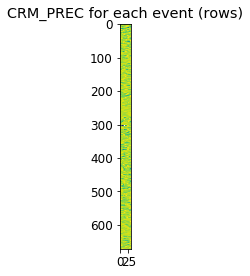

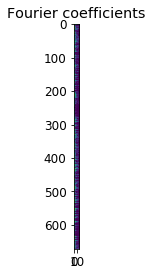

crmprind: [[1 6 4 ..., 0 0 0]
 [3 0 2 ..., 0 0 0]
 [2 0 1 ..., 0 0 0]
 ..., 
 [4 2 0 ..., 0 0 0]
 [0 1 5 ..., 2 0 0]
 [2 1 0 ..., 0 0 0]]
locmin: [[1, 4, 13, 17, 20, 25, 28], [4, 15, 21, 27], [3, 14, 17], [0, 7, 15], [2, 10, 15, 29], [3, 6, 15, 19], [3, 8, 25], [0, 2, 8, 17, 20, 29], [2, 9, 22, 26], [3, 11, 13, 16, 24, 26, 30], [7, 11, 22, 24, 29], [4, 12, 15, 31], [4, 9, 12, 15, 17, 23], [6, 15, 19, 27], [1, 13, 16, 18, 26], [20, 23, 26, 28], [6, 10, 17, 22, 29], [0, 3, 7, 12, 17, 28], [2, 5, 9, 14, 21], [2, 4, 8, 14, 17, 27], [2, 4, 11, 18, 24, 27, 29], [0, 7, 12, 18, 24], [11, 18, 27], [5, 23], [7, 17, 22, 26, 30], [5, 10, 16, 22], [3, 6, 15, 29], [5, 10, 17, 21, 27], [2, 11, 14, 18, 23, 26, 30], [1, 13, 26, 31], [4, 30], [6, 20, 25], [2, 6, 12, 15, 23, 31], [2, 8, 13, 18, 23], [6, 11, 14, 23, 28], [2, 7, 10, 21, 24], [0, 9, 11], [3, 6, 10, 15, 18, 23, 29, 31], [3, 13, 31], [9, 25], [0, 11, 18, 26, 29], [7, 14, 22, 26, 28, 31], [3, 7, 14, 19, 22, 25, 29], [4, 11, 15, 17, 19, 30], [1

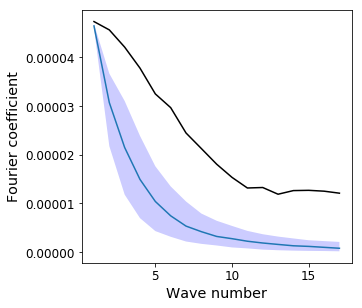

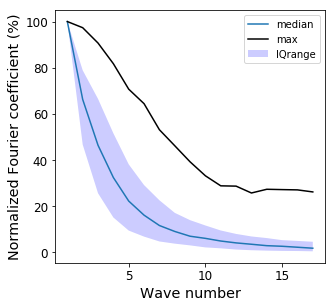

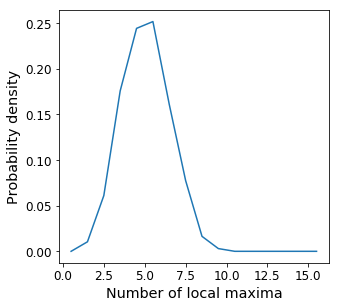

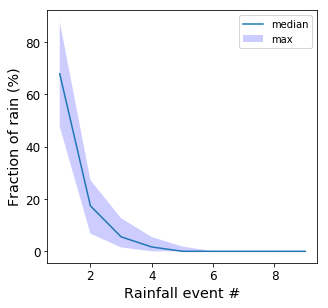

In [12]:
##-- EXPLORE FFT ANALYSIS --##

# Dimensions of embedded CRMs
ndim1,ndim2 = s_crm2D[1:3]

# For all bins, compute the spatial characteristics of the crm precipitation field
# for rank in targetranks:

rank = targetranks[26]
rankid = rankID(rank)
iQ = indexOfRank(rank,ranks_ref)
print(rank)
print("P_Q =",percentiles[iQ])
print("bin:",bins[iQ-1],bins[iQ])
print()

# Points corresponding to extreme event
stencil_Q = rank_locations[rankid]

# Extend stencil to dimensions of crm variables
crm_stencil_Q = np.repeat(np.repeat(stencil_Q[:,np.newaxis,np.newaxis,...],ndim1,1),
                          ndim2,2)
# Extract CRM_PREC data at percentile of PRECT
# crmpr_all_prQ = crmpr[crm_stencil_Q].reshape((stencil_Q.sum(),ndim2))
crmpr_all_prQ = np.stack([crmpr[:,0,i,:,:][stencil_Q] for i in range(32)]).T

crmpr_avg_all_prQ = np.mean(crmpr_all_prQ,axis=1)
pr_all_prQ = pr[stencil_Q]

# See if the average of PRECT in the percentile bin matches the percentile P_Q
print("All values of pr in percentile bin:",pr_all_prQ)
print("Fraction of values between bin edges:",(np.logical_and(pr_all_prQ<=bins[iQ],pr_all_prQ>bins[iQ-1])).sum()/pr_all_prQ.size)
print("Average of pr in percentile bin:",np.mean(pr_all_prQ), pr_prQ[iQ])
# See if the average of CRM_PREC along crm_x within the percentile bin matches the percentile P_Q
print()
print("All values of crmpr in percentile bin:",crmpr_avg_all_prQ)
print("Fraction of values between bin edges:",(np.logical_and(crmpr_avg_all_prQ<=bins[iQ],
                                                              crmpr_avg_all_prQ>bins[iQ-1])).sum()/crmpr_avg_all_prQ.size)
print("Average of crmpr in percentile bin:",np.mean(crmpr_avg_all_prQ))
print()
print("Local relative error between pr and crmpr_avg:",(crmpr_avg_all_prQ-pr_all_prQ)/pr_all_prQ)

print(crmpr_all_prQ.shape)
plt.imshow(np.log(crmpr_all_prQ))
plt.title('CRM_PREC for each event (rows)')
plt.show()

crmpr_all_fft_prQ = np.absolute(np.fft.fft(crmpr_all_prQ,axis=1))[:,:(ndim2//2+1)]
plt.imshow(crmpr_all_fft_prQ)
plt.title('Fourier coefficients')
plt.show()

crmpr_fft_IQrange_prQ = np.percentile(crmpr_all_fft_prQ,[25,50,75],axis=0)
crmpr_fft_I25_prQ,crmpr_fft_I50_prQ,crmpr_fft_I75_prQ = tuple(crmpr_fft_IQrange_prQ)
crmpr_fft_max_prQ = np.max(crmpr_all_fft_prQ,axis=0)

# Plot median and interquartile range of coefficients without normalizing
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
x = np.arange(1,18,1)
ax.plot(x,crmpr_fft_I50_prQ)
ax.plot(x,crmpr_fft_max_prQ,'k')
ax.fill_between(x, crmpr_fft_I25_prQ, crmpr_fft_I75_prQ, where=crmpr_fft_I75_prQ >= crmpr_fft_I25_prQ,
                facecolor='b',alpha=0.2, interpolate=True)
ax.set_xlabel('Wave number')
ax.set_ylabel('Fourier coefficient')

def mainCoef(fft_array):
    """The array is 2D with fft dimension in second position"""
    main_coef = np.apply_along_axis(arr=fft_array,axis=1,func1d=lambda x: np.argmax(x == np.max(x)))
    return main_coef
    
crmpr_fft_maincoef_prQ = mainCoef(crmpr_all_fft_prQ)

# Normalize data
crmpr_all_fftrel_prQ = np.apply_along_axis(arr=crmpr_all_fft_prQ,axis=1,func1d=lambda x: x/np.max(x))
crmpr_fftrel_IQrange_prQ = np.percentile(crmpr_all_fftrel_prQ,[25,50,75],axis=0)
crmpr_fftrel_I25_prQ,crmpr_fftrel_I50_prQ,crmpr_fftrel_I75_prQ = tuple(crmpr_fftrel_IQrange_prQ)
crmpr_fftrel_max_prQ = np.max(crmpr_all_fftrel_prQ,axis=0)

# Plot median and interquartile range of coefficients after normalizing
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
x = np.arange(1,18,1)
ax.plot(x,crmpr_fftrel_I50_prQ*100)
ax.plot(x,crmpr_fftrel_max_prQ*100,'k')
ax.fill_between(x, crmpr_fftrel_I25_prQ*100, crmpr_fftrel_I75_prQ*100, where=crmpr_fftrel_I75_prQ >= crmpr_fftrel_I25_prQ,
                facecolor='b',alpha=0.2, interpolate=True)
ax.set_xlabel('Wave number')
ax.set_ylabel('Normalized Fourier coefficient (%)')
ax.legend(['median','max','IQrange'],framealpha=0.8)


# Compute number of local maxima (number of blobs, or clouds) point by point
crmpr_all_nmax_prQ = np.apply_along_axis(arr=crmpr_all_prQ,axis=1,func1d=numLocalMax)
dens,edges = np.histogram(crmpr_all_nmax_prQ,bins=np.linspace(0,16,17),density=True)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
ax.plot(np.convolve(edges,(0.5,0.5),'valid'),dens)
ax.set_xlabel('Number of local maxima')
ax.set_ylabel('Probability density')

# Compute the fraction of rain in each sub rain event (between consecutive local minima)
crmpr_frac_and_ind_prQ = [fractionRainPerEvent(x) for x in crmpr_all_prQ]
ll = [l[0] for l in crmpr_frac_and_ind_prQ]
crmprfrac_prQ = np.array(list(zip_longest(*ll,fillvalue=0))).T
ll = [l[1] for l in crmpr_frac_and_ind_prQ]
crmprind_prQ = np.array(list(zip_longest(*ll,fillvalue=0))).T
print("crmprind:",crmprind_prQ)

# Median and IQrange - fraction of rain
crmprfrac_IQrange_prQ = np.percentile(crmprfrac_prQ,[25,50,75],axis=0)
crmprfrac_I25_prQ,crmprfrac_I50_prQ,crmprfrac_I75_prQ = tuple(crmprfrac_IQrange_prQ)

locmin_prQ = [list(np.where(localMin(x))[0]) for x in crmpr_all_prQ]
print("locmin:",locmin_prQ)

# Size of biggest rain event
crmprsize_prQ = np.array([(np.roll(locmin_prQ[k],-1)[crmprind_prQ[k][0]]-locmin_prQ[k][crmprind_prQ[k][0]]) % ndim2 for k in range(crmprind_prQ.shape[0])])
print("Size of largest contributing event",crmprsize_prQ)

# Plot median and interquartile range of fraction of rain
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
x = np.arange(1,len(crmprfrac_I50_prQ)+1,1)
ax.plot(x,crmprfrac_I50_prQ*100)
ax.fill_between(x,crmprfrac_I25_prQ*100, crmprfrac_I75_prQ*100,
                  where=crmprfrac_I75_prQ >= crmprfrac_I25_prQ,
                  facecolor='b',alpha=0.2, interpolate=True)
ax.set_xlabel('Rainfall event #')
ax.set_ylabel('Fraction of rain (%)')
ax.legend(['median','max','IQrange'],framealpha=0.8)


##-- END EXPLORE FFT ANALYSIS --##

In [37]:
##-- FFT analysis on all percentiles --##

# Dimensions of embedded CRMs
ndim1,ndim2 = s_crm2D[1:3]

# Initialize outputs
# crmpr_fft_mainWN_prQ = np.nan*np.empty((targetranks.size,ndim2))
crmpr_fft_I25_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fft_I50_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fft_I75_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fft_max_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fftrel_I25_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fftrel_I50_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fftrel_I75_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_fftrel_max_prQ = np.nan*np.empty((ranks_ref.size,ndim2//2))
crmpr_nmax_I25_prQ = np.nan*np.empty((ranks_ref.size,ndim2))
crmpr_nmax_I50_prQ = np.nan*np.empty((ranks_ref.size,ndim2))
crmpr_nmax_I75_prQ = np.nan*np.empty((ranks_ref.size,ndim2))
crmpr_nmax_max_prQ = np.nan*np.empty((ranks_ref.size,ndim2))
crmprfrac_I25_prQ = np.nan*np.empty((ranks_ref.size,7))
crmprfrac_I50_prQ = np.nan*np.empty((ranks_ref.size,7))
crmprfrac_I75_prQ = np.nan*np.empty((ranks_ref.size,7))
crmprsize_I25_prQ = np.nan*np.empty((ranks_ref.size,))
crmprsize_I50_prQ = np.nan*np.empty((ranks_ref.size,))
crmprsize_I75_prQ = np.nan*np.empty((ranks_ref.size,))

# For all bins, compute the spatial characteristics of the crm precipitation field
for rank in targetranks:

    rankid = rankID(rank)
    stencil_Q = rank_locations[rankid]
    iQ = indexOfRank(rank,ranks_ref)
    print(rankid,end=', ')

#     # Extend stencil to dimensions of crm variables
#     crm_stencil_Q = np.repeat(np.repeat(stencil_Q[:,np.newaxis,np.newaxis,...],ndim1,1),
#                               ndim2,2)
    # Extract CRM_PREC data at percentile of PRECT
    crmpr_all_Q = np.stack([crmpr[:,0,i,:,:][stencil_Q] for i in range(ndim2)]).T
    
    plt.figure()
    if crmpr_all_prQ.shape[0] > 100:
        X = crmpr_all_Q[:100,]
    else:
        X = crmpr_all_Q
    plt.imshow(X)
    plt.savefig(os.path.join(figdir,time_stride,resolution,'crmpr_pr_Q%s_%s.pdf'%(rankid.replace('.',''),output_suffix)),
            bbox_inches='tight')
    plt.close()
    
    # Compute Fourier coefficient point by point
    crmpr_all_fft_Q = np.absolute(np.fft.fft(crmpr_all_Q,axis=1))[:,:(ndim2//2)]

    plt.figure()
    if crmpr_all_fft_Q.shape[0] > 100:
        X = crmpr_all_fft_Q[:100,]
    else:
        X = crmpr_all_fft_Q
    plt.imshow(X)
    plt.savefig(os.path.join(figdir,time_stride,resolution,'FFT_crmpr_pr_Q%s_%s.pdf'%(rankid.replace('.',''),output_suffix)),
            bbox_inches='tight')
    plt.close()
    
    # Compute number of local maxima (number of blobs, or clouds) point by point
    crmpr_all_nmax_Q = np.apply_along_axis(arr=crmpr_all_Q,axis=1,func1d=numLocalMax)
    
    
    #- Interquartile range and median without normalizing
    crmpr_fft_IQrange_Q = np.percentile(crmpr_all_fft_Q,[25,50,75],axis=0)
    crmpr_fft_I25_Q,crmpr_fft_I50_Q,crmpr_fft_I75_Q = tuple(crmpr_fft_IQrange_Q)
    crmpr_fft_max_Q = np.max(crmpr_all_fft_Q,axis=0)
    # Wavenumber or maximum coefficient
    crmpr_fft_maincoef_Q = mainCoef(crmpr_all_fft_Q)

    # Normalize data
    crmpr_all_fftrel_Q = np.apply_along_axis(arr=crmpr_all_fft_Q,axis=1,func1d=lambda x: x/np.max(x))
    # Interquartile range and median after normalizing
    crmpr_fftrel_IQrange_Q = np.percentile(crmpr_all_fftrel_Q,[25,50,75],axis=0)
    crmpr_fftrel_I25_Q,crmpr_fftrel_I50_Q,crmpr_fftrel_I75_Q = tuple(crmpr_fftrel_IQrange_Q)
    crmpr_fftrel_max_Q = np.max(crmpr_all_fftrel_Q,axis=0)

    # Plot median and interquartile range of coefficients after normalizing
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
    x = np.arange(1,17,1)
    ax.plot(x,crmpr_fftrel_I50_Q*100)
    ax.plot(x,crmpr_fftrel_max_Q*100,'k')
    ax.fill_between(x, crmpr_fftrel_I25_Q*100, crmpr_fftrel_I75_Q*100, where=crmpr_fftrel_I75_Q >= crmpr_fftrel_I25_Q,
                    facecolor='b',alpha=0.2, interpolate=True)
    ax.set_xlabel('Wave number')
    ax.set_ylabel('Normalized Fourier coefficient (%)')
    ax.legend(['median','max','quartiles'],framealpha=0.8)
    plt.savefig(os.path.join(figdir,time_stride,resolution,'IQrange_and_max_FFTnormalized_crmpr_pr_Q%s_%s.pdf'%(rankid.replace('.',''),output_suffix)),
            bbox_inches='tight')
    plt.close()
    
    # Compute the fraction of rain in each sub rain event (between consecutive local minima)
    crmpr_frac_and_ind_Q = [fractionRainPerEvent(x) for x in crmpr_all_Q]
    ll = [l[0] for l in crmpr_frac_and_ind_Q]
    crmprfrac_Q = np.array(list(zip_longest(*ll,fillvalue=0))).T 
    nshort = 7 - crmprfrac_Q.shape[1]
    if nshort > 0:
        crmprfrac_Q = np.pad(crmprfrac_Q, [(0,0),(0,nshort)], 'constant', constant_values=0)
    
    ll = [l[1] for l in crmpr_frac_and_ind_Q]
    crmprind_Q = np.array(list(zip_longest(*ll,fillvalue=0))).T

    # Median and IQrange - fraction of rain
    crmprfrac_IQrange_Q = np.percentile(crmprfrac_Q,[25,50,75],axis=0)
    crmprfrac_I25_Q,crmprfrac_I50_Q,crmprfrac_I75_Q = tuple(crmprfrac_IQrange_Q)

    # Size of biggest rain event
    locmin_Q = [list(np.where(localMin(x))[0]) for x in crmpr_all_Q]
    crmprsize_Q = np.array([(np.roll(locmin_Q[k],-1)[crmprind_Q[k][0]]-locmin_Q[k][crmprind_Q[k][0]]) % ndim2 for k in range(crmprind_Q.shape[0])],
                           dtype=float)
    # Median and IQrange or largest event size
    crmprsize_IQrange_Q = np.percentile(crmprsize_Q,[25,50,75],axis=0)
    crmprsize_I25_Q,crmprsize_I50_Q,crmprsize_I75_Q = tuple(crmprsize_IQrange_Q)
    
    #- Store data
#     crmpr_fft_mainWN_prQ[iQ,:] = crmpr_fft_maincoef_Q
    crmpr_fft_I25_prQ[iQ,:] = crmpr_fft_I25_Q
    crmpr_fft_I50_prQ[iQ,:] = crmpr_fft_I50_Q
    crmpr_fft_I75_prQ[iQ,:] = crmpr_fft_I75_Q
    crmpr_fft_max_prQ[iQ,:] = crmpr_fft_max_Q
    # After normalizing
    crmpr_fftrel_I25_prQ[iQ,:] = crmpr_fftrel_I25_Q
    crmpr_fftrel_I50_prQ[iQ,:] = crmpr_fftrel_I50_Q
    crmpr_fftrel_I75_prQ[iQ,:] = crmpr_fftrel_I75_Q
    crmpr_fftrel_max_prQ[iQ,:] = crmpr_fftrel_max_Q
    # Fraction of rain in rain events
    crmprfrac_I25_prQ[iQ,:] = crmprfrac_I25_Q[:7]
    crmprfrac_I50_prQ[iQ,:] = crmprfrac_I50_Q[:7]
    crmprfrac_I75_prQ[iQ,:] = crmprfrac_I75_Q[:7]
    # Event size
    crmprsize_I25_prQ[iQ] = crmprsize_I25_Q
    crmprsize_I50_prQ[iQ] = crmprsize_I50_Q
    crmprsize_I75_prQ[iQ] = crmprsize_I75_Q

print()

84.1511, 87.4107, 90.0000, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411, 99.0000, 99.2057, 99.3690, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741, 99.9000, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.9800, 99.9842, 99.9874, 99.9900, 


Show the fraction of rain in the largest event as a function of percentile rank


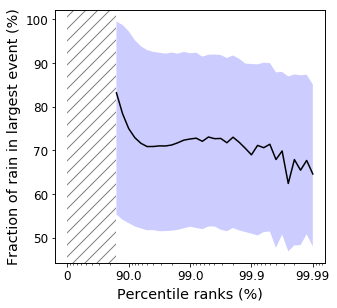

In [38]:
print("Show the fraction of rain in the largest event as a function of percentile rank")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

# ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 crmprfrac_I50_prQ[:,0]*100,
                 col='k',ltype='-',transformX=False)

subplotYShadingRanksILog(ax,ranks_ref,[crmprfrac_I25_prQ[:,0]*100,crmprfrac_I75_prQ[:,0]*100],col='blue',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)
    
ax.set_xlabel('Percentile ranks (%)')
ax.set_ylabel('Fraction of rain in largest event (%)')
plt.show()
# ax.legend(['median','max','quartiles'],framealpha=0.8)
# plt.savefig(os.path.join(figdir,time_stride,resolution,'IQrange_and_max_FFTnormalized_crmpr_pr_Q%s_%s.pdf'%(rankid.replace('.',''),output_suffix)),
#         bbox_inches='tight')


Show the fraction areao of the largest event as a function of percentile rank


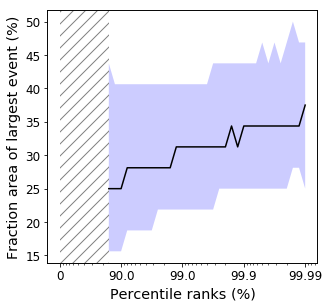

In [39]:
print("Show the fraction areao of the largest event as a function of percentile rank")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

# Add zero line
addZeroLine(ax,ranks_ref)

subplotRanksILog(ax,ranks_ref,
                 crmprsize_I50_prQ/float(ndim2)*100,
                 col='k',ltype='-',transformX=False)

subplotYShadingRanksILog(ax,ranks_ref,
                         [crmprsize_I25_prQ/float(ndim2)*100,crmprsize_I75_prQ/float(ndim2)*100],
                         col='blue',transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)
    
ax.set_xlabel('Percentile ranks (%)')
ax.set_ylabel('Fraction area of largest event (%)')
plt.show()

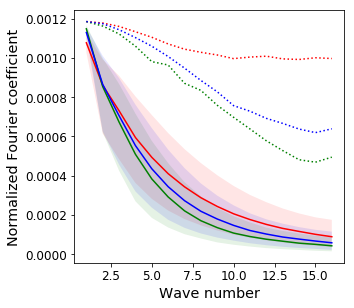

In [43]:
# Plot median and interquartile range of Fourier coefficients computed after normalizing
iQ1 = indexOfRank(96.8377,ranks_ref)
iQ2 = indexOfRank(99.6838,ranks_ref)
iQ3 = indexOfRank(99.0684,ranks_ref)
iQs = [iQ1,iQ2,iQ3]

normfac = [1,
           crmpr_fft_max_prQ[iQs[0]][0]/crmpr_fft_max_prQ[iQs[1]][0],
           crmpr_fft_max_prQ[iQs[0]][0]/crmpr_fft_max_prQ[iQs[2]][0]]

cols = 'r','g','b'

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))
x = np.arange(1,17,1)
for i in range(3):
    fac = normfac[i]
    ax.plot(x,fac*crmpr_fft_I50_prQ[iQs[i]]*100,c=cols[i])
    ax.plot(x,fac*crmpr_fft_max_prQ[iQs[i]]*100,linestyle=':',c=cols[i])
    ax.fill_between(x, fac*crmpr_fft_I25_prQ[iQs[i]]*100, fac*crmpr_fft_I75_prQ[iQs[i]]*100,
                    where=fac*crmpr_fft_I75_prQ[iQs[i]] >= fac*crmpr_fft_I25_prQ[iQs[i]],
                facecolor=cols[i],alpha=0.1, interpolate=True)
ax.set_xlabel('Wave number')
ax.set_ylabel('Normalized Fourier coefficient')
# ax.legend(['median','max','IQrange'],framealpha=0.8)

TODO: Put same color scale as preivous paper

## Save results

In [44]:
print("save results to dataframe")

vars_to_pickle = ['crmpr_fft_I25_prQ',
    'crmpr_fft_I50_prQ',
    'crmpr_fft_I75_prQ',
    'crmpr_fft_max_prQ',
    'crmpr_fftrel_I25_prQ',
    'crmpr_fftrel_I50_prQ',
    'crmpr_fftrel_I75_prQ',
    'crmpr_fftrel_max_prQ',
    # Fraction of rain in rain events
    'crmprfrac_I25_prQ',
    'crmprfrac_I50_prQ',
    'crmprfrac_I75_prQ',
    # Event size
    'crmprsize_I25_prQ',
    'crmprsize_I50_prQ',
    'crmprsize_I75_prQ']

save results to dataframe


In [45]:
size_pickle = 0
dict_pickle = {}
for v in vars_to_pickle:
    obj = getattr(thismodule,v)
    size_pickle += sys.getsizeof(obj)
    if obj.__class__ is np.ndarray:
        print('.',v,obj.__class__,sys.getsizeof(obj),obj.shape)
    else:
        print('.',v,obj.__class__,sys.getsizeof(obj))
    # save variables
    dict_pickle[v] = obj

. crmpr_fft_I25_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fft_I50_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fft_I75_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fft_max_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fftrel_I25_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fftrel_I50_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fftrel_I75_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmpr_fftrel_max_prQ <class 'numpy.ndarray'> 5360 (41, 16)
. crmprfrac_I25_prQ <class 'numpy.ndarray'> 2408 (41, 7)
. crmprfrac_I50_prQ <class 'numpy.ndarray'> 2408 (41, 7)
. crmprfrac_I75_prQ <class 'numpy.ndarray'> 2408 (41, 7)
. crmprsize_I25_prQ <class 'numpy.ndarray'> 424 (41,)
. crmprsize_I50_prQ <class 'numpy.ndarray'> 424 (41,)
. crmprsize_I75_prQ <class 'numpy.ndarray'> 424 (41,)


In [46]:
result_dict_file = 'subgridscale_results_dictionary_%s.pickle'%output_suffix
print("> save to file %s"%result_dict_file)
pickle.dump(dict_pickle,open(os.path.join(resultdir,result_dict_file),"wb"))
print("total size =",size_pickle,"B")

> save to file subgridscale_results_dictionary_Q8-Q41_185005010100-185105010000.pickle
total size = 51376 B
